In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from itertools import count
import math
import swifter
from lightgbm import LGBMRanker

In [2]:
data = pd.read_csv("../../repos/learningRepos_descr_go_scaled.csv")

In [3]:
data.head(10)

,query,rank,repo_name,star_count,pull_count,is_official,is_automated,repo_owner,short_description,significant_levenshtein,significant_position,significant_category,significant_jaccard,is_standalone,query_find
0,atu,1,atu,0.000000,3.713572,0,0,jemydocker,NaN,1.000000,1.0,1.00,1.000000,1,1
1,atu,2,atu-aos-php50639,0.000000,5.068904,0,0,kyokofi,ATU AOS PHP 5.6.39,0.187500,1.0,0.50,0.230769,0,1
2,atu,3,atu-aos-php730,0.000000,4.682131,0,0,kyokofi,ATU AOS - PHP7.3.0 + APACHE,0.214286,1.0,0.50,0.272727,0,1
3,atu,4,atu-iot-nodejs,0.000000,4.465908,0,0,kyokofi,ATU IoT - NodeJS + redis + npm + nginx,0.214286,1.0,0.50,0.272727,0,1
4,atu,5,atul-public-repo,0.000000,11.787173,0,0,atularora99,NaN,0.500000,1.0,0.33,0.428571,0,3
5,atu,6,splunk,1.386294,12.812076,0,0,atunnecliffe,"Based on Alpine, provides a quick and simple S...",-0.500000,1.0,0.33,0.333333,0,2
6,atu,7,atu-aos-php720,0.000000,3.713572,0,0,kyokofi,ATU AOS - PHP7.2.0 + APACHE,0.214286,1.0,0.50,0.272727,0,1
7,atu,8,java-python,1.098612,12.335666,0,0,aturner,NaN,0.636364,1.0,0.33,0.500000,0,2
8,atu,9,kops,0.000000,11.732760,0,0,atulabhi,NaN,-0.250000,1.0,0.33,0.428571,0,2
9,atu,10,node-python,0.000000,12.148051,0,0,aturner,NaN,0.636364,1.0,0.33,0.500000,0,2


In [8]:
features = ["star_count", "pull_count", "is_official", "is_automated",
		"significant_levenshtein", "significant_position", "significant_category", "significant_jaccard", "is_standalone", "query_find"]
categorical_features = ['query_find']

In [6]:
group_sizes = data.groupby('query').size()
valid_queries = group_sizes[group_sizes >= 5].index
data = data[data['query'].isin(valid_queries)].copy()

data['label'] = data.groupby('query')['rank'].transform(lambda r: r.max() - r + 1)

In [9]:
unique_queries = data['query'].unique()
train_queries, test_queries = train_test_split(unique_queries, test_size=0.2, random_state=42)

train_data = data[data['query'].isin(train_queries)].copy()
test_data = data[data['query'].isin(test_queries)].copy()

train_group = train_data.groupby('query').size().tolist()
test_group = test_data.groupby('query').size().tolist()

train_dataset = lgb.Dataset(train_data[features], label=train_data['label'], group=train_group,categorical_feature=categorical_features)
test_dataset = lgb.Dataset(test_data[features], label=test_data['label'], group=test_group, reference=train_dataset,categorical_feature=categorical_features)



In [24]:
params = {
            'objective': 'lambdarank',
            'metric': 'ndgc',
            'ndcg_eval_at': [10, 30, 50, 100],
            'learning_rate': 0.07,
            'num_leaves': 77,
            'min_data_in_leaf': 30,
            'verbose': -1,
            "label_gain": list(range(0, 101)),
            #"boosting_type": "gbdt"
        }

model = lgb.train(params, train_dataset, valid_sets=[test_dataset], num_boost_round=100)

In [25]:
test_data['pred'] = model.predict(test_data[features])

In [26]:
spearman_scores = []
full_ndcg_scores = []
group_sizes = []
same_scores_all = []

for q in test_queries:
    group = test_data[test_data['query'] == q]
    if len(group) < 5:
        continue
    true_ranks = group['rank'].values
    pred_scores = group['pred'].values
    group = group.sort_values(by='pred', ascending=False)
    same_scores=0
    for i in range(len(group) - 1):
        if group.iloc[i]['pred'] == group.iloc[i+1]['pred']:
            same_feat = (group.iloc[i][features].values == group.iloc[i + 1][features].values).all()
            if not same_feat:
                same_scores += 1
    try:
        corr, _ = spearmanr(true_ranks, -pred_scores)
        if np.isnan(corr):
            print(true_ranks, -pred_scores,"da")
            continue
        spearman_scores.append(corr)
    except:
        print(true_ranks, -pred_scores)
        continue

    true_relevance = group['label'].values.reshape(1, -1)
    predicted = group['pred'].values.reshape(1, -1)
    ndcg_full = ndcg_score(true_relevance, predicted)
    full_ndcg_scores.append(ndcg_full)
    group_sizes.append(len(group))
    same_scores_all.append(same_scores/len(group))

In [27]:
print(f"\nSpearman Rank Correlation (avg): {np.mean(spearman_scores):.4f}")
print(f"Full NDCG (avg): {np.mean(full_ndcg_scores):.4f}")
print(f"Same Scores for same Features: {np.mean(same_scores_all):.4f}")


Spearman Rank Correlation (avg): 0.9111
Full NDCG (avg): 0.9906
Same Scores for same Features: 0.0337


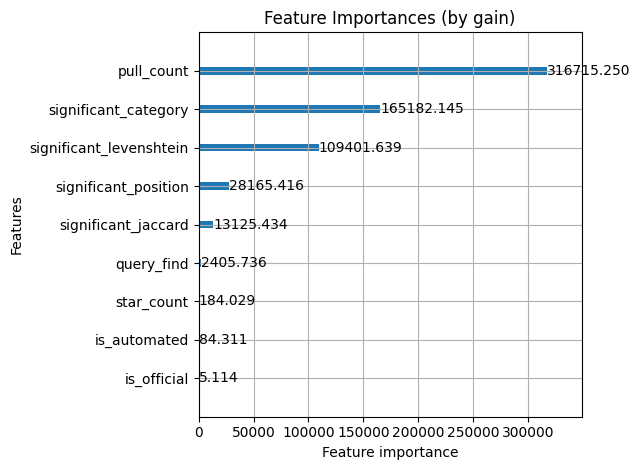

In [28]:
lgb.plot_importance(model, max_num_features=30, importance_type='gain')
plt.title("Feature Importances (by gain)")
plt.tight_layout()
plt.show()

In [29]:
model.save_model("docker_ranker.txt")